## Import Packages

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

## Load Dataset

In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/ktxdev/mind-matters/refs/heads/master/data/cleaned/train.csv")
data.head()

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,...,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Academic Pressure Applicable,CGPA Applicable,Study Satisfaction Applicable,Work Pressure Applicable,Job Satisfaction Applicable
0,Female,49.0,Ludhiana,Working Professional,Chef,-1.0,5.0,-1.00,-1.0,2.0,...,No,1.0,2.0,No,0,0,0,0,1,1
1,Male,26.0,Varanasi,Working Professional,Teacher,-1.0,4.0,-1.00,-1.0,3.0,...,Yes,7.0,3.0,No,1,0,0,0,1,1
2,Male,33.0,Visakhapatnam,Student,Student,5.0,-1.0,8.97,2.0,-1.0,...,Yes,3.0,1.0,No,1,1,1,1,0,0
3,Male,22.0,Mumbai,Working Professional,Teacher,-1.0,5.0,-1.00,-1.0,1.0,...,Yes,10.0,1.0,Yes,1,0,0,0,1,1
4,Female,30.0,Kanpur,Working Professional,Business Analyst,-1.0,1.0,-1.00,-1.0,1.0,...,Yes,9.0,4.0,Yes,0,0,0,0,1,1


## Feature Engineering & Feature Cleaning

In [9]:
# Standardize numerical features
data = standardize_numerical_features(data)
# Encode categorical variables
data = encode_categorical_features(data)

## Feature Selection

Optimal number of features: 106


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

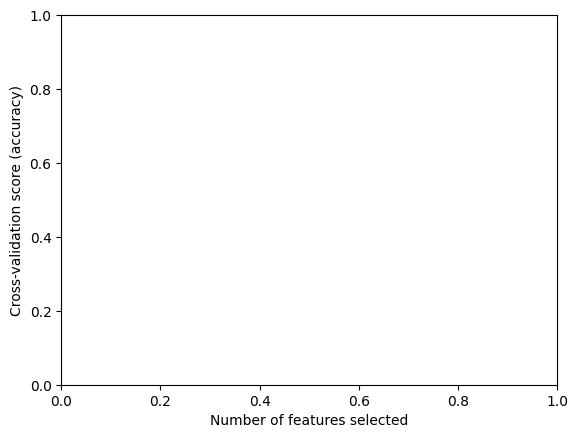

In [11]:
X = data.drop('Depression', axis=1)
y = data['Depression']

# Define the model
model = RandomForestClassifier(random_state=42)

# Apply RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X, y)

# Plot RFECV results
cv_scores = rfecv.cv_results_['mean_test_score']

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(cv_scores) + 1), cv_scores)
plt.show()

#### Insights:
- As the number of features increases, the cross-validation accuracy improves sharply at the beginning (up to around 20 features)
- This suggests that the most important predictive features are captured within the first 20 features
- After ~20 features, the accuracy starts to plateau, indicating diminishing returns from adding more features
- Adding more features beyond this point likely introduces redundant or less informative features, which do not significantly improve the model's performance
- The "elbow point" (where the curve transitions from a sharp rise to a plateau) is a good candidate for the optimal number of features to select. This seems to be around 20-30 features in this plot
- Including all 117 features may lead to overfitting, especially if some features are irrelevant or noisy, even though the cross-validation score remains stable

In [16]:
# Fit RFE
rfe = RFE(estimator=model, n_features_to_select=20)
rfe.fit(X, y)

# Store selected features
selected_features = X.columns[rfe.support_]
data = pd.concat([X[selected_features], y.reset_index(drop=True)], axis=1).head()

Age: Rank 1
Academic Pressure: Rank 1
Work Pressure: Rank 1
CGPA: Rank 1
Study Satisfaction: Rank 1
Job Satisfaction: Rank 1
Work/Study Hours: Rank 1
Financial Stress: Rank 1
Academic Pressure Applicable: Rank 1
CGPA Applicable: Rank 1
Study Satisfaction Applicable: Rank 1
Work Pressure Applicable: Rank 16
Job Satisfaction Applicable: Rank 2
City_Ahmedabad: Rank 5
City_Bangalore: Rank 32
City_Bhopal: Rank 26
City_Chennai: Rank 28
City_Delhi: Rank 42
City_Faridabad: Rank 48
City_Ghaziabad: Rank 35
City_Hyderabad: Rank 14
City_Indore: Rank 24
City_Jaipur: Rank 25
City_Kalyan: Rank 8
City_Kanpur: Rank 45
City_Kolkata: Rank 17
City_Lucknow: Rank 22
City_Ludhiana: Rank 13
City_Meerut: Rank 30
City_Mumbai: Rank 37
City_Nagpur: Rank 38
City_Nashik: Rank 46
City_Other: Rank 95
City_Patna: Rank 18
City_Pune: Rank 15
City_Rajkot: Rank 12
City_Srinagar: Rank 9
City_Surat: Rank 20
City_Thane: Rank 21
City_Vadodara: Rank 23
City_Varanasi: Rank 27
City_Vasai-Virar: Rank 10
City_Visakhapatnam: Rank 1

In [35]:
selected_data = pd.concat([X[selected_features], y.reset_index(drop=True)], axis=1)

In [36]:
selected_data

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Academic Pressure Applicable,CGPA Applicable,...,Working Professional or Student_Working Professional,Gender_Male,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Degree_Class 12,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes,Depression
0,0.695360,-0.466166,1.375429,-0.488770,-0.464194,-0.091904,-1.363057,-0.699617,0,0,...,True,False,False,False,False,False,False,False,False,0
1,-1.161867,-0.466166,0.883136,-0.488770,-0.464194,0.400871,0.193928,0.007793,0,0,...,True,True,False,True,False,True,False,True,False,1
2,-0.596624,2.938341,-1.578329,2.348688,1.315556,-1.570231,-0.844062,-1.407027,1,1,...,False,True,False,False,False,False,False,True,False,1
3,-1.484863,-0.466166,1.375429,-0.488770,-0.464194,-0.584680,0.972421,-1.407027,0,0,...,True,True,False,True,True,False,False,True,True,1
4,-0.838871,-0.466166,-0.593743,-0.488770,-0.464194,-0.584680,0.712923,0.715203,0,0,...,True,False,False,False,False,True,False,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,-1.807859,-0.466166,1.375429,-0.488770,-0.464194,0.893647,-1.103560,0.715203,0,0,...,True,False,False,False,False,True,True,False,True,1
140696,0.049368,-0.466166,1.375429,-0.488770,-0.464194,0.893647,-0.065570,1.422613,0,0,...,True,False,True,False,True,False,False,True,True,0
140697,-1.323365,-0.466166,0.390843,-0.488770,-0.464194,-0.584680,-0.584565,0.715203,0,0,...,True,False,False,False,True,False,False,False,False,0
140698,0.695360,-0.466166,1.375429,-0.488770,-0.464194,-0.091904,0.972421,-1.407027,0,0,...,True,False,False,False,True,False,False,True,False,0


In [37]:
save_data(selected_data, 'cleaned', 'train')

Dataframe saved!


In [39]:
selected_features

Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress', 'Academic Pressure Applicable', 'CGPA Applicable',
       'Study Satisfaction Applicable',
       'Working Professional or Student_Working Professional', 'Gender_Male',
       'Sleep Duration_7-8 hours', 'Sleep Duration_Less than 5 hours',
       'Dietary Habits_Moderate', 'Dietary Habits_Unhealthy',
       'Degree_Class 12', 'Have you ever had suicidal thoughts ?_Yes',
       'Family History of Mental Illness_Yes'],
      dtype='object')